# Argument Intent Linter

The previous notebooks have all focused on using Loki to perform code transformations. Loki can also be used as a Fortran linter. In this notebook, we will use Loki to check whether the declared intent of a subroutine argument is consistent with how that variable is used.

For brevity, only the core functionality of a subroutine dummy argument intent-linter is developed here.

Let us start by first examining the sample subroutine that we will use to illustrate this notebook:

In [1]:
from loki import Sourcefile

source = Sourcefile.from_file('src/intent_test.F90')
print(source.to_fortran())



MODULE kernel_mod
  USE parkind1, ONLY: jpim, jprb
  IMPLICIT NONE
  CONTAINS
  SUBROUTINE some_kernel (n, vout, var_out, var_in, var_inout, b, l, h, y)
    
    INTEGER(KIND=jpim), INTENT(IN) :: n, l, b
    INTEGER(KIND=jpim), INTENT(IN) :: h
    REAL(KIND=jprb), INTENT(IN) :: var_in(n)
    REAL(KIND=jprb), INTENT(INOUT) :: var_out(n)
    REAL(KIND=jprb), INTENT(INOUT) :: var_inout(n)
    REAL(KIND=jprb), INTENT(INOUT) :: vout(n)
    REAL(KIND=jprb), INTENT(INOUT) :: y(:)
    
  END SUBROUTINE some_kernel
END MODULE kernel_mod

SUBROUTINE intent_test (m, n, var_in, var_out, var_inout, tendency_loc)
  USE parkind1, ONLY: jpim, jprb
  USE kernel_mod, ONLY: some_kernel
  USE yoecldp, ONLY: nclv
  IMPLICIT NONE
  
  INTEGER(KIND=jpim), INTENT(IN) :: m, n
  INTEGER(KIND=jpim) :: i, j, k, h, l
  REAL(KIND=jprb), INTENT(IN) :: var_in(n, n, n)
  REAL(KIND=jprb), TARGET, INTENT(OUT) :: var_out(n, n, n)
  REAL(KIND=jprb), INTENT(INOUT) :: var_inout(n, n, n)
  REAL(KIND=jprb), ALLOCATABLE :: x(

## Retrieving variable intent

We can access all the variables declared in subroutine `intent_test` using the `variables` property of the [_Subroutine_](https://sites.ecmwf.int/docs/loki/main/loki.subroutine.html#loki.subroutine.Subroutine) object:

In [2]:
routine = source['intent_test']
print('vars::', ', '.join([str(v) for v in routine.variables]))


vars:: m, n, i, j, k, h, l, var_in(n, n, n), var_out(n, n, n), var_inout(n, n, n), x(:), y(:), vout(n), tendency_loc


In the Loki IR, variables are stored as symbols with base `class` [_MetaSymbol_](https://sites.ecmwf.int/docs/loki/main/loki.expression.symbols.html#loki.expression.symbols.MetaSymbol) and the `intent` of a variable is stored in the `property` [`MetaSymbol.type`](https://sites.ecmwf.int/docs/loki/main/loki.expression.symbols.html#loki.expression.symbols.MetaSymbol.type). To retrieve all variables with declared intent, we only need to look through the subroutine `arguments`:

In [3]:
from collections import defaultdict

intent_vars = defaultdict(list)
for var in routine.arguments:
    intent_vars[var.type.intent].append(var)

in_vars = intent_vars['in']
out_vars = intent_vars['out']
inout_vars = intent_vars['inout']

print('in::', ', '.join([str(v) for v in in_vars]), 'out::', ', '.join([str(v) for v in out_vars]), 'inout::', ','.join([str(v) for v in inout_vars]))
assert all([len(in_vars) == 3, len(out_vars) == 2, len(inout_vars) == 1])


in:: m, n, var_in(n, n, n) out:: var_out(n, n, n), tendency_loc inout:: var_inout(n, n, n)


## Separating variables from dimensions

In Loki, the most general way of retrieving the variables used in an expression or node is the [_FindVariables_](https://sites.ecmwf.int/docs/loki/main/loki.expression.expr_visitors.html#loki.expression.expr_visitors.FindVariables) visitor. In the IR nodes in the body of a subroutine, the `FindVariables` visitor will return variables that appear in their own right, as well as any variables used for array indexing. An example of this is seen when `FindVariables` is applied to an [_Allocation_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Allocation):

In [4]:
from loki import FindNodes, FindVariables, Allocation

alloc = FindNodes(Allocation).visit(routine.body)[0]
alloc_vars = FindVariables().visit(alloc.variables)
print(', '.join([str(v) for v in alloc_vars]))


x(n), n


Utilities to distingiush between variables and their dimensions can be constructed by wrapping small functions around `FindVariables`:

In [5]:
from loki import Array, flatten

def findvarsnotdims(o, return_vars=True):
    """Return list of variables excluding any array dimensions."""

    dims = flatten([FindVariables().visit(var.dimensions) for var in FindVariables().visit(o) if isinstance(var, Array)])

#   remove duplicates from dims
    dims = list(set(dims))

    if return_vars:
        return [var for var in FindVariables().visit(o) if not var in dims]

    return [var.name for var in FindVariables().visit(o) if not var in dims]

def finddimsnotvars(o, return_vars=True):
    """Return list of all array dimensions."""

    dims = flatten([FindVariables().visit(var.dimensions) for var in FindVariables().visit(o) if isinstance(var, Array)])

#   remove duplicates from dims
    dims = list(set(dims))

    if return_vars:
        return dims

    return [var.name for var in dims]


A quick test reveals:

In [6]:
print(f'vars:{findvarsnotdims(alloc.variables, return_vars=False)}')
print(f'dims:{finddimsnotvars(alloc.variables, return_vars=False)}')

assert len(findvarsnotdims(alloc.variables)) == 1
assert len(finddimsnotvars(alloc.variables)) == 1


vars:['x']
dims:['n']


## Resolving associations

You may have noticed that `intent_test` contains several nested associations. The simplest way of dealing with these is to resolve all the associations before we begin linting the program:

In [7]:
from loki import fgen, SubstituteExpressions, Associate, Transformer

assoc_map = {}
for assoc in FindNodes(Associate).visit(routine.body):
    vmap = {}
    for rexpr, lexpr in assoc.associations:
        vmap.update({var: rexpr for var in FindVariables().visit(assoc.body) if lexpr == var})
    assoc_map[assoc] = SubstituteExpressions(vmap).visit(assoc.body)
routine.body = Transformer(assoc_map).visit(routine.body)
print(fgen(routine.body))



ALLOCATE (x(n))
ALLOCATE (y(m))

DO k=1,n
  DO j=1,n
    DO i=1,n
      var_out(i, j, k) = 2._jprb
    END DO
    
    var_out(m:n, j, k) = var_in(m:n, j, k) + var_inout(m:n, j, k) + var_out(m:n, j, k)
    
    vout => var_out(:, j, k)
    
    CALL some_kernel(n, vout, vout, var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    NULLIFY (vout)
    
    
    CALL some_kernel(n, tendency_loc%cld(:, j, k), var_out(:, j, k), var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    
    DO i=1,n
      var_inout(i, j, k) = var_out(i, j, k)
    END DO
  END DO
END DO

DEALLOCATE (x)
DEALLOCATE (y)



In Loki, an [_Associate_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Associate) statement is a `ScopedNode`. A `ScopedNode` is a mix-in that attaches to an [_InternalNode_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.InternalNode). It declares a new scope that sits within the `Subroutine` scope, but also defines a few of its own symbols. This means that the new variables declared in an `Associate` statement are only in scope in the body of that particular node. Therefore to resolve the associations we can simply apply the [_SubstituteExpressions_](https://sites.ecmwf.int/docs/loki/main/loki.expression.expr_visitors.html#loki.expression.expr_visitors.SubstituteExpressions) visitor to the `Associate`'s body, as shown in the previous code-cell.

Resolving pointer associations that use the `=>` operator is a little more involved. Firstly, pointers and targets must be declared in the `Subroutine` specification, unlike an `Associate` statement which declares new symbols. It would thus be wrong to think of a pointer association as having its own localised scope. Secondly, an associated pointer can be disassociated either by exiting the encompassing scope (i.e. exiting the `Subroutine`), by using the [_Nullify_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Nullify) intrinsic or by assigning to `NULL()`.

Therefore before we can apply the `SubstituteExpressions` visitor to resolve pointer associations, we must first determine the *range* of nodes over which the pointer is valid. The best way to do so is to develop a bespoke visitor: 

In [8]:
from loki import Assignment

class FindPointerRange(FindNodes):
    """Visitor to find range of nodes over which pointer associations apply."""


    def __init__(self, match, greedy=False):

        super().__init__(match, mode='type', greedy=greedy)
        self.rule = lambda match, o: o == match
        self.stat = False

    def visit_Assignment(self, o, **kwargs):
        """
        Check for pointer assignment (=>). Also check if pointer is disassociated,
        else add the node to the returned list.
        """

        ret = kwargs.pop('ret', self.default_retval())
        if self.rule(self.match, o):
            assert not self.stat # we should only visit the pointer assignment node once
            self.stat = True
        elif self.match.lhs in findvarsnotdims(o.lhs) and 'null' in [v.name.lower for v in findvarsnotdims(o.rhs)]:
            assert self.stat
            self.stat = False
            ret.append(o)
        elif self.stat:
            ret.append(o)
        return ret or self.default_retval()

    def visit_Nullify(self, o, **kwargs):
        """
        Check if pointer is disassociated, else add the node to the returned list.
        """

        ret = kwargs.pop('ret', self.default_retval())
        if self.match.lhs in findvarsnotdims(o.variables):
            assert self.stat
            self.stat = False
            ret.append(o)
        elif self.stat:
            ret.append(o)
        return ret or self.default_retval()

    def visit_Node(self, o, **kwargs):
        """
        Add the node to the returned list if stat is True and visit
        all children.
        """

        ret = kwargs.pop('ret', self.default_retval())
        if self.stat:
            ret.append(o)
            if self.greedy:
                return ret
        for i in o.children:
            ret = self.visit(i, ret=ret, **kwargs)
        return ret or self.default_retval()

for assign in [a for a in FindNodes(Assignment).visit(routine.body) if a.ptr]:
    nodes = FindPointerRange(assign).visit(routine.body)
    for node in nodes[:-1]:
        print(node)


Comment:: 
Call:: some_kernel
Comment:: 


As the above output shows, our new visitor correctly identifies all three nodes over which the pointer association applies. We can now finally proceed to resolve the pointer association:

In [9]:
pointer_map = {}
for assign in [a for a in FindNodes(Assignment).visit(routine.body) if a.ptr]:
    nodes = FindPointerRange(assign).visit(routine.body)
    pointer_map[assign] = None
    for node in nodes[:-1]:
        vmap = {var: assign.rhs for var in FindVariables().visit(node) if assign.lhs == var}
        pointer_map[node] = SubstituteExpressions(vmap).visit(node)
    pointer_map[nodes[-1]] = None
routine.body = Transformer(pointer_map).visit(routine.body)
print(fgen(routine.body))



ALLOCATE (x(n))
ALLOCATE (y(m))

DO k=1,n
  DO j=1,n
    DO i=1,n
      var_out(i, j, k) = 2._jprb
    END DO
    
    var_out(m:n, j, k) = var_in(m:n, j, k) + var_inout(m:n, j, k) + var_out(m:n, j, k)
    
    
    CALL some_kernel(n, var_out(:, j, k), var_out(:, j, k), var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    
    
    CALL some_kernel(n, tendency_loc%cld(:, j, k), var_out(:, j, k), var_in(:, j, k), var_inout(:, j, k), 1, h=n, l=5, y=y)
    
    
    DO i=1,n
      var_inout(i, j, k) = var_out(i, j, k)
    END DO
  END DO
END DO

DEALLOCATE (x)
DEALLOCATE (y)



## Modifying variable values

Putting aside function or subroutine calls for the moment (and also ignoring I/O), there are only two mechanisms for modifying the value of a variable. The obvious one is an [_Assignment_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Assignment) statement, where the `rhs` value is assigned to the `lhs` value.

Values can also be assigned to a variable by using it as the induction variable of a loop. Although an extremely unusual practice, Fortran compilers do allow dummy arguments of kind `intent(out)` or `intent(inout)`  to be used as the induction variables of a loop. This is however (in my humble opinion) bad coding practice; for ease of readability, local variables rather than dummy arguments should be used as loop induction variables. Therefore in our linter rules, we will forbid the use of variables with declared `intent` as loop induction variables.

To enable us to check all our linter rules in just one pass of the subroutine's IR, we will create a new visitor: `IntentLinterVisitor`. The next section creates the `IntentLinterVisitor` visitor and defines linter rules for checking `intent` consistency within the `Subroutine` body. We will later examine how this can be extended to subroutine calls.

## Checking `intent` in `Subroutine` body

Let us first define an initialization method for an instance of `IntentLinterVisitor`, and a method to check for rule violations:

In [10]:
from loki import Visitor

class IntentLinterVisitor(Visitor):
    """Visitor to check for dummy argument intent violations."""

    def __init__(self, in_vars, out_vars, inout_vars):  # pylint: disable=redefined-outer-name
        """Initialise an instance of the intent linter visitor."""

        super().__init__()
        self.in_vars = in_vars
        self.out_vars = out_vars
        self.inout_vars = inout_vars
        self.var_check = {var: True for var in (in_vars + out_vars + inout_vars)}

        self.vars_read = set(in_vars + inout_vars)
        self.vars_written = set()
        self.alloc_vars = set() # set of variables that are allocated

    def rule_check(self):
        """Check rule-status for all variables with declared intent."""

        for v, s in self.var_check.items():
            assert s, f'intent({v.type.intent}) rule broken for {v.name}'
        print('All rules satisfied')


You may have noticed that in defining our new visitor, we also introduced an attribute called `alloc_vars`. This is intended to accumulate the variables allocated in a subroutine. The reason for including this attribute will be clear later on.

We can now proceed to define the rules for our linter. The rule to check whether variables with declared intent are used as loop induction variables can be implemented as follows:

In [11]:
def visit_Loop(self, o, **kwargs):
    """
    Check if loop induction variable has declared intent, update vars_read/vars_written
    if variables with declared intent are used in loop bounds and visit any nodes in loop body.
    """

    if o.variable.type.intent:
        self.var_check[o.variable] = False
        print(f'intent({o.variable.type.intent}) {o.variable.name} used as loop induction variable.')
    for v in [v for v in FindVariables().visit(o.bounds) if v.type.intent]:
        if v not in self.vars_read | self.vars_written:
            print(f'undefined intent({v.type.intent}) variable {v.name} used for loop bounds.')
            self.var_check[v] = False
        self.vars_read.add(v)
        self.vars_written.discard(v)
    self.visit(o.body, **kwargs)

IntentLinterVisitor.visit_Loop = visit_Loop


For `intent(in)` variables, we don't want their value to be reassigned in the `Subroutine`. Therefore the rule for checking `intent(in)` variables is the simplest: variables of kind `intent(in)` should not appear in the `lhs` of an `Assignment`. The rule for `intent(out)` variables is that upon entry to a subroutine, a value must be assigned to them before the variable can be used: `intent(out)` variables must be written to before they can be read. For `Assignment` statements, the above rules can be implemented as follows:

In [12]:
def visit_Assignment(self, o):
    """Check intent rules for assignment statements."""

    if o.lhs.type.intent == 'in':
        print(f'value of intent(in) var {o.lhs.name} modified')
        self.var_check[o.lhs] = False

    self.vars_written.add(o.lhs)
    self.vars_read.discard(o.lhs)

    for v in FindVariables().visit(o.rhs):
        if v.type.intent == 'out' and v not in self.vars_read | self.vars_written:
            print('intent(out) var read from before being written to.')
            self.var_check[v] = False
        elif v.type.intent:
            self.vars_read.add(v)
            self.vars_written.discard(v)

IntentLinterVisitor.visit_Assignment = visit_Assignment


In principle we could also build similar checks for `intent(inout)` variables. However, the way in which some Fortran compilers treat `allocatable` variables prevents us from doing so.

If an `allocatable` array is passed to a subroutine as a dummy argument of kind `intent(out)`, some Fortran compilers will deallocate that array upon exiting the subroutine. This is why in the IFS, data arrays are sometimes declared as `intent(inout)` even if their true intent is `intent(out)`. An example can be seen in the 'cloudsc-dwarf' in `src/cloudsc_driver_mod.F90`: the `REAL` array `PCOVPTOT` is declared `intent(inout)` even though it's value entering the subroutine is never used.

An allocatable array passed as a dummy argument to a subroutine could thus belong to two possible categories:
1. A variable that is truly of type `intent(inout)`
2. A variable that is strictly of type `intent(out)`, but has been declared `intent(inout)` to avoid deallocation

It would be very difficult to discern between the two options from a static analysis of the source code. As such, we will not impose any rules related to `Assignment` expressions for `intent(inout)` variables.

We can however impose the rule that the dummy argument corresponding to an `allocatable` array must be of kind `intent(inout)` or `intent(in)`. To enable a `visit_CallStatement` method to perform this check, we first need a `visit_Allocation` method that updates the `alloc_vars` set:

In [13]:
def visit_Allocation(self, o):
    """
    Update set of allocated variables and read/written sets for variables used to define
    allocation size.
    """

    self.alloc_vars.update(o.variables)
    for v in [v for v in finddimsnotvars(o.variables) if v.type.intent]:
        if v not in self.vars_read | self.vars_written:
            print(f'undefined intent({v.type.intent}) variable {v.name} used to set allocation size.')
            self.var_check[v] = False
        self.vars_read.add(v)
        self.vars_written.discard(v)

IntentLinterVisitor.visit_Allocation = visit_Allocation


We are now ready to implement a `visit_CallSatement` method.

## Building `intent` map between function caller and callee

We have already defined one linter rule for `CallStatement`s; dummy arguments corresponding to `allocatable` variables must of type `intent(in)` or `intent(inout)`. Another very important check we have to perform is to ensure that the declared `intent` of a dummy argument is consistent with the `intent` of the argument in the calling (parent) subroutine.

For example, `var_in` is a variable of kind `intent(in)` in `Subroutine` `intent_test`. Therefore `var_in` must not be modified within `intent_test` or any subroutines called by `intent_test`. Hence in `some_kernel`, `var_in` must also be of kind `intent(in)`.

The mapping for `intent(out)` variables is a little more complicated and depends on whether before the [_CallStatement_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.CallStatement), the variable in question has ever been written to, and if so, whether the value last assigned to it has been read at least once. The procedure for building the mapping is best illustrated using the flowchart below:

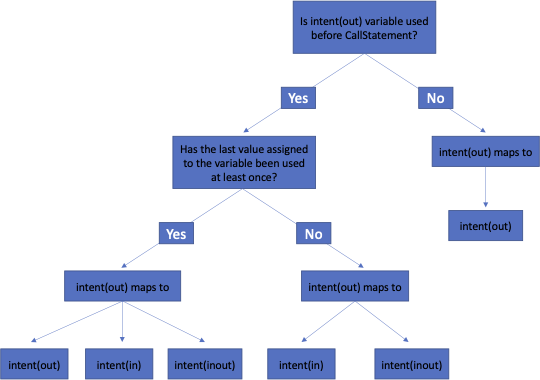

In [14]:
from IPython.display import Image

fig = Image(filename='gfx/intent_out_map-crop.png')
fig


A similar process can be used to determine the mapping for `intent(inout)` variables:

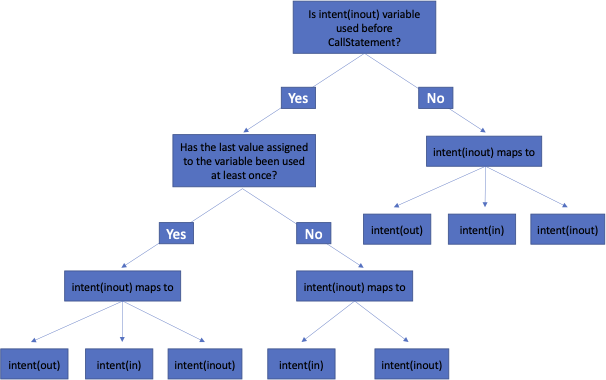

In [15]:
fig = Image(filename='gfx/intent_inout_map-crop.png')
fig


You may be wondering why `intent(out)` has been included as a permitted value for the rightmost tree of the above flowchart. It is to account for the following possibility: an `allocatable` variable is allocated in subroutine A, and passed as an argument to subroutine B. Subroutine B must therefore declare the variable as either `intent(inout)` or `intent(in)`. Subroutine B then passes the variable as an argument to subroutine C without using it first. In subroutine C, the variable can correctly be of any declared intent.

## Checking `intent` consistency across function calls

The code below gives an example of how a `visit_CallStatement` method can be implemented:

In [16]:
intent_map = {'in': {'none': ['in'], 'lhs': ['in'], 'rhs': ['in']}}
intent_map['out'] = {'none': ['out'], 'lhs': ['in', 'inout'], 'rhs': ['in', 'inout', 'out']}
intent_map['inout'] = {'none': ['in', 'inout', 'out'], 'lhs': ['in', 'inout'], 'rhs': ['in', 'inout', 'out']}

def visit_CallStatement(self, o):
    """
    Check intent consistency across callstatement and check intent of
    dummy arguments corresponding to allocatables.
    """

    assign_type = {v.name: 'none' for v in self.in_vars + self.out_vars + self.inout_vars}
    assign_type.update({v.name: 'lhs' for v in self.vars_written})
    assign_type.update({v.name: 'rhs' for v in self.vars_read})

    for f, a in o.arg_iter():
        if getattr(getattr(a, 'type', None), 'intent', None):
            if f.type.intent not in intent_map[a.type.intent][assign_type[a.name]]:
                print(f'Inconsistent intent in {o} for arg {a.name}')
            if f.type.intent in ['in']:
                self.vars_read.add(a)
                self.vars_written.discard(a)
            else:
                self.vars_written.add(a)
                self.vars_read.discard(a)
        if getattr(a, "name", None) in [v.name for v in self.alloc_vars]:
            if not f.type.intent in ['in', 'inout']:
                print(f'Allocatable argument {a.name} has wrong intent in {o.routine}.')

IntentLinterVisitor.intent_map = intent_map
IntentLinterVisitor.visit_CallStatement = visit_CallStatement
routine.enrich(source.all_subroutines) # link CallStatements to Subroutines


In the final line of the above code-cell, we called the function `enrich`. This uses inter-procedural analysis to link `CallStatement` nodes to the relevant `Subroutine` objects. Also note that in the above code-cell, `intent_map` has been declared as a class-attribute because it will be the same for every instance of `IntentLinterVisitor`. 

We can now finally run our intent-linter and check if any rules are broken:

In [17]:
intent_linter = IntentLinterVisitor(in_vars, out_vars, inout_vars)
intent_linter.visit(routine.body)
intent_linter.rule_check()


All rules satisfied
